# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)  # calculate the number of batches
        for batch in range(num_batches):  # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(y,z)).astype(np.float32)
                    else:
                        image = resize(image,(100,100)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0  #normalise and feed in the image
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            
            
        # write the code for the remaining data points which are left after full batches
            
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(y,z)).astype(np.float32)
                    else:
                        image = resize(image,(y,z)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0  
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0  
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0 

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
    

In [5]:
#Shortcut Function to create Kernels

def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [6]:
#Shortcut Function to visulaize model results 

def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Conv3D

## Cnv3d-(Model 1)

>> #### 18 Frames | Image_size= 100 * 100 | Batch Size = 20 | Epoch = 10

In [ ]:
batch_size =20     #experiment with the batch size 20
x=18               #experiment with the Framea size  18
y=100              #experiment with the image Height 100
z=100              #experiment with the image width  100
num_epochs = 10   #experiment with the Epoch 10

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 18, 100, 100, 64)  5248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 18, 100, 100, 64)  256       
_________________________________________________________________
activation_4 (Activation)    (None, 18, 100, 100, 64)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 9, 50, 100, 64)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 9, 50, 100, 128)   221312    
_________________________________________________________________
batch_normalization_5 (Batch (None, 9, 50, 100, 128)   512       
_________________________________________________________________
activation_5 (Activation)    (None, 9, 50, 100, 128)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'Cnv3d-(Model 1)' + '_' + '18_100_100_20_10' +'_'+ str(curr_dt_time).replace(' ','').replace(':','_')+'/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - 1966s 59s/step - loss: 3.2367 - categorical_accuracy: 0.3741 - val_loss: 6.9240 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to Cnv3d-(Model 1)_18_100_100_32_30_2021-10-1605_35_54.630108/model-00001-3.23674-0.37406-6.92404-0.23000.h5
Epoch 2/10
34/34 [==============================] - 202s 6s/step - loss: 1.7610 - categorical_accuracy: 0.5008 - val_loss: 5.5181 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to Cnv3d-(Model 1)_18_100_100_32_30_2021-10-1605_35_54.630108/model-00002-1.76096-0.50075-5.51806-0.39000.h5
Epoch 3/10
34/34 [==============================] - 198s 6s/step - loss: 1.4077 - categorical_accuracy: 0.5641 - val_loss: 2.8473 - val_categorical_accuracy: 0.3100

Epoch 00003: saving model to Cnv3d-(Model 1)_18_100_100_32_30_2021-10-1605_35_54.630108/model-00003-1.40771-0.56410-2.84726-0.31000.h5
Epoch 4

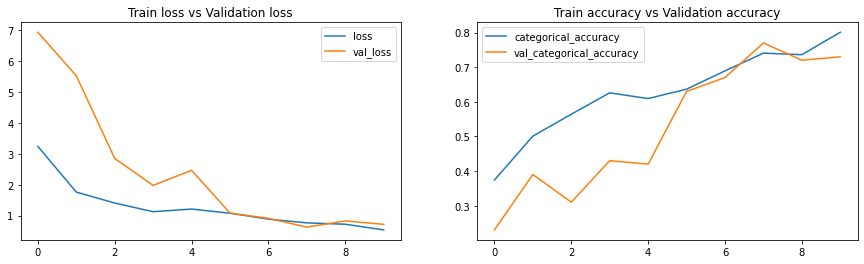

Max. Training Accuracy 0.8009049892425537
Max. Validaiton Accuracy 0.7699999809265137


In [ ]:
plotModelHistory(model1)

## Cnv3d-(Model 2)

>> ####  18 Frames | Image_size= 100 * 100 | Batch Size = 25 | Epoch = 20

In [ ]:
batch_size =25    #experiment with the batch size 25
x=18             #experiment with the Frame size  18
y=100              #experiment with the image Height 100
z=100              #experiment with the image width  100
num_epochs = 20   #experiment with the Epoch 20

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 18, 100, 100, 64)  5248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 18, 100, 100, 64)  256       
_________________________________________________________________
activation (Activation)      (None, 18, 100, 100, 64)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 50, 100, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 9, 50, 100, 128)   221312    
_________________________________________________________________
batch_normalization_5 (Batch (None, 9, 50, 100, 128)   512       
_________________________________________________________________
activation_1 (Activation)    (None, 9, 50, 100, 128) 

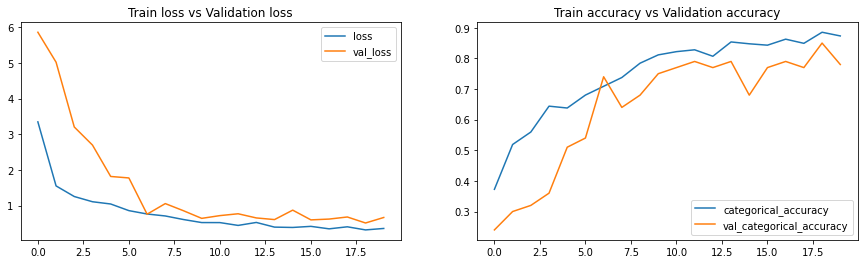

Max. Training Accuracy 0.8853695392608643
Max. Validaiton Accuracy 0.8500000238418579


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


#Compliation

sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


#Genrator Creation 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


# Callback Document Saving ".h5"

model_name = 'Cnv3d-(Model 2)' + '_' + '16_100_100_25_20' +'_'+ str(curr_dt_time).replace(' ','').replace(':','_')+'/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]



# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
    
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.'''


model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


plotModelHistory(model1)

## Cnv3d-(Model 3)

> ##### 20 Frames | Image_size= 100 * 100 |   Batch Size = 64    |    Epoch = 50    |   Batch Normalization before Maxpooling   |   Kernel_Size - (2,2,2)   |    Activation_Function-"Relu"    |    Optimizer - "Adam"

In [ ]:
batch_size =64     #experiment with the batch size 64
x=20               #experiment with the Frame size  20
y=100              #experiment with the image Height 100
z=100              #experiment with the image width  100
num_epochs = 50   #experiment with the Epoch 50

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 100, 100, 16)  64        
_________________________________________________________________
activation_24 (Activation)   (None, 20, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 50, 100, 16)   0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 50, 100, 32)   4128      
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 50, 100, 32)   128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 50, 100, 32)  

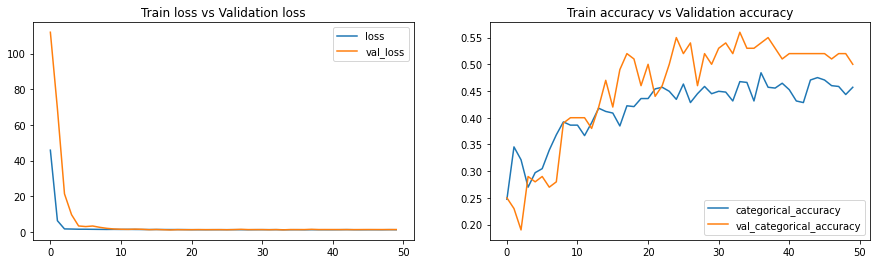

Max. Training Accuracy 0.4841628968715668
Max. Validaiton Accuracy 0.5600000023841858


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()
model.add(Conv3D(16, (2,2,2), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(32, (2,2,2), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))


model.add(Conv3D(64, (2,2,2), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))
model.add(Dropout(0.25))


model.add(Conv3D(128, (2,2,2), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


#Compliation

adam = optimizers.Adam()
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


#Genrator Creation 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


# Callback Document Saving ".h5"

model_name = 'Cnv3d-(Model 3)' + '_' + '20_100_100_64_50' +'_'+ str(curr_dt_time).replace(' ','').replace(':','_')+'/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]



# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
    
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.'''


model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model1)

# Conv2D  + RNN

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(y,z)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(y,z)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

##  Cnv2d_RNN-(Model 1)

>> #### 15 Frames | Image_size= 120 * 120 | Batch Size = 32 | Epoch = 30

In [ ]:
batch_size =32     #experiment with the batch size 32
x=15               #experiment with the Frame size  15
y=120             #experiment with the image Height 120
z=120              #experiment with the image width  120
num_epochs = 30   #experiment with the Epoch 30

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 121s 6s/step - loss: 1.5623 - categorical_accuracy: 0.2956 - val_loss: 1.6902 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to Cnv2d+RNN-(Model 1)_(15,120,120,32)_2021-10-1605_35_54.630108/model-00001-1.56228-0.29563-1.69016-0.18000.h5
Epoch 2/30
21/21 [==============================] - 115s 6s/step - loss: 1.4460 - categorical_accuracy: 0.3756 - val_loss: 1.7993 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to Cnv2d+RNN-(Model 1)_(15,120,120,32)_2021-10-1605_35_54.630108/model-00002-1.44604-0.37557-1.79929-0.18000.h5
Epoch 3/30
21/21 [==============================] - 112s 6s/step - loss: 1.3730 - categorical_accuracy: 0.4238 - val_loss: 1.8004 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to Cnv2d+RNN-(Model 1)_(15,120,120,32)_2021-10-1605_35_54.630108/model-00003-1.37296-0.42383-1.80043-0.22000.h5


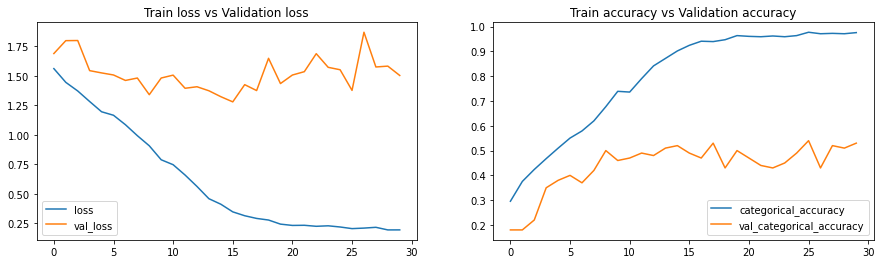

Max. Training Accuracy 0.9773755669593811
Max. Validaiton Accuracy 0.5400000214576721


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16

        
model = Sequential()
model.add(TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=(15,120,120,3))),
model.add(TimeDistributed(BatchNormalization())),
model.add(TimeDistributed(MaxPooling2D(make2dFilter(2)))),
model.add(TimeDistributed(Flatten())),
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compliation
adam= optimizers.Adam()
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


#Genrator Creation 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)




# Callback Document Saving ".h5"

model_name = 'Cnv2d+RNN-(Model 1)' + '_' + '(15,120,120,32,30)' +'_'+ str(curr_dt_time).replace(' ','').replace(':','_')+'/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]





# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

    
    

    
    
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.'''


model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model1)


##  Cnv2d_RNN-(Model 2)

>> #### 20 Frames | Image_size= 120 * 120 | Batch Size = 32 | Epoch = 20 | Adding More Layers | Without Drop outs

In [ ]:
batch_size =32     #experiment with the batch size 32
x=20               #experiment with the Frame size  20
y=120             #experiment with the image Height 120
z=120              #experiment with the image width  120
num_epochs = 20   #experiment with the Epoch 20

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 30, 30, 64)   

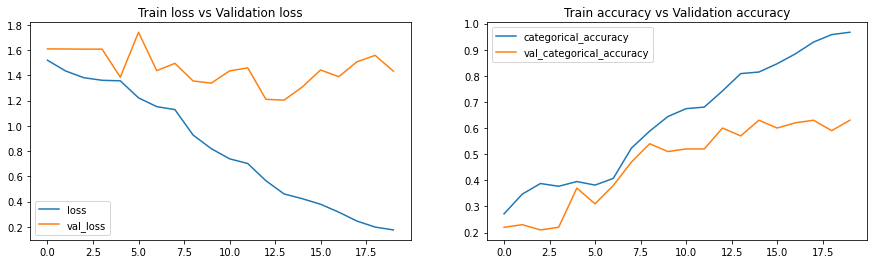

Max. Training Accuracy 0.9668174982070923
Max. Validaiton Accuracy 0.6299999952316284


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16

        
model = Sequential()
model.add(TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=(20,120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))

model.add(TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu'), input_shape=(20,120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))

model.add(TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu'), input_shape=(20,120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))

model.add(TimeDistributed(Flatten())),
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compliation
adam= optimizers.Adam()
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


#Genrator Creation 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)




# Callback Document Saving ".h5"

model_name = 'Cnv2d+RNN-(Model 2)' + '_' + '(20,120,120,32,20)' +'_'+ str(curr_dt_time).replace(' ','').replace(':','_')+'/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]





# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

    
    

    
    
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.'''


model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


plotModelHistory(model1)

##  Cnv2d_RNN-(Model 3)

> #### 20 Frames | Image_size= 120 * 120 | Batch Size = 32 | Epoch = 20 | Adding More Layers | With  Drop outs

In [ ]:
batch_size =32     #experiment with the batch size 32
x=20              #experiment with the Framea size  20
y=120             #experiment with the image Height 120
z=120              #experiment with the image width  120
num_epochs = 20   #experiment with the Epoch 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
dropout (Dropout)            (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 30, 30, 32)    0

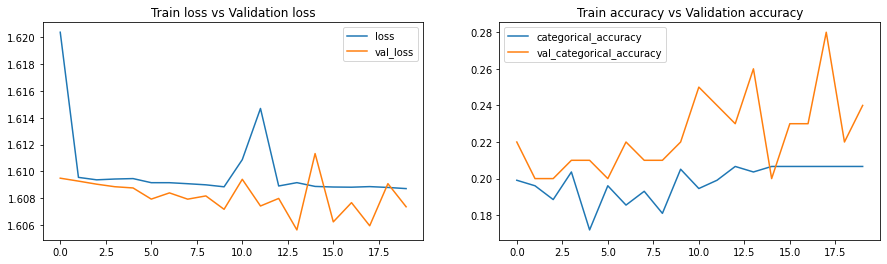

Max. Training Accuracy 0.20663650333881378
Max. Validaiton Accuracy 0.2800000011920929


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16

        
model = Sequential()
model.add(TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=(20,120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))

model.add(TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu'), input_shape=(20,120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.5))
model.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))


model.add(TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu'), input_shape=(20,120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))


model.add(TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu'), input_shape=(20,120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.5))
model.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))



model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compliation
adam= optimizers.Adam()
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


#Genrator Creation 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)




Callback Document Saving ".h5"

model_name = 'Cnv2d+RNN-(Model 3)' + '_' + '(20,120,120,32,20)' +'_'+ str(curr_dt_time).replace(' ','').replace(':','_')+'/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]





# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

    
    

    
    
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.'''


model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     callbacks=callbacks_list,validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



plotModelHistory(model1)

# Transfer Learning(CNN)  + RNN(GRU)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output 
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
         # write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

## TL_VGG16_GRU(Model1)

> #### 18 Frames | Image_size= 120 * 120 | Batch Size = 32 | Epoch = 20

In [ ]:
batch_size =32   #experiment with the batch size 32
x=18        #experiment with the Frame size 18
y=120        #experiment with the image height 120
z=120         #experiment with the batch Width 120
num_epochs=20   #experiment with the batch size 20

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, None, 512)         14714688  
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 512)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 15,307,333
Trainable params: 15,307,333
Non-trainable params: 0
_________________________________________________________________
None
Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - 2175s 105s/step - loss: 2962.6409 - categorical_accuracy: 0.1885 - val_loss: 483.4127 - val_cat

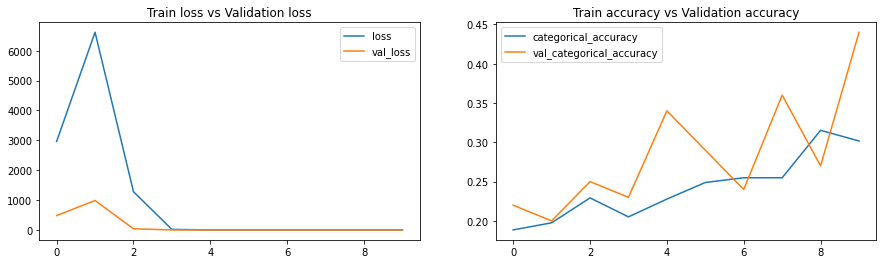

Max. Training Accuracy 0.3152337968349457
Max. Validaiton Accuracy 0.4399999976158142


In [ ]:
from tensorflow.python.keras.applications import imagenet_utils

from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam



base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

base_model = Model(inputs=base_model.input, outputs=x)

model = Sequential()

model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))
model.add(GRU(256, activation='relu', dropout=0.5))
model.add(Dense(5, activation = 'softmax'))

#Compliation
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

#Genrator Creation 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'TL_VGG16_GRU(Model1)' + '_' + '(18,120,120,32,20)' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]



if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



    
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.'''


model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model1)


## TL_EfficientNetB0_GRU(Model2)

> #### 18 Frames | Image_size= 120 * 120 | Batch Size = 20 | Epoch = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])  # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

         # write the code for the remaining data points which are left after full batches
        
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [10]:
batch_size =20   #experiment with the batch size 20
x=18        #experiment with the Frame size 18
y=120        #experiment with the image height 120
z=120         #experiment with the batch Width 120b
num_epochs=20  #experiment with the batch size 20

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 1280)        4049571   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1280)        0         
_________________________________________________________________
gru (GRU)                    (None, 64)                258432    
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 4,308,328
Trainable params: 4,266,305
Non-trainable params: 42,023
_________________________________________________________________
None
Source path =  train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 396s 11s/step - loss: 0.9482 - categorical_accuracy: 0.6109 - val_loss: 1.8112

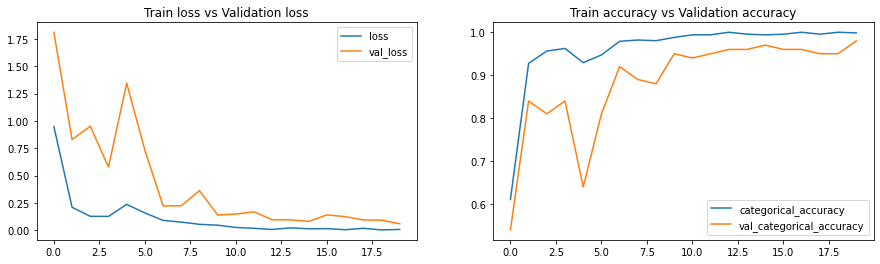

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.9800000190734863


In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend
from tensorflow.python.keras.applications import imagenet_utils
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(120,120,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

base_model = Model(inputs=base_model.input, outputs=x)

model = Sequential()

model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))
model.add(GRU(64, activation='relu', dropout=0.5))
model.add(Dense(5, activation = 'softmax'))

#Compliation
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

#Genrator Creation 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'TL_EfficientNetB0(Model2)' + '_' + '(18,120,120,20,20)' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]



if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



    
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.'''


model1= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model1)